In [5]:
import pandas as pd
import json
import sklearn

In [6]:
# Load cleaned charging data
charging_data: pd.DataFrame = pd.read_pickle('data/charging_modified.pkl')

# Print head
charging_data.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,NoChargingTime,...,kWhPerMinute,month,user_paymentRequired_values,user_userID,user_requestedDeparture,user_modifiedAt,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile
Index,,,,,,,,,,,,,,,,,,,,,
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1,AG-3F30,1-1-179-810,194.0,0 days 01:39:40,...,0.095233,1,True,194.0,"Thu, 02 Jan 2020 20:51:54 GMT","Thu, 02 Jan 2020 13:09:39 GMT",463.0,100.0,25.0,250.0
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1,AG-1F01,1-1-193-825,4275.0,0 days 02:20:16,...,0.082485,1,True,4275.0,"Thu, 02 Jan 2020 23:31:50 GMT","Thu, 02 Jan 2020 13:37:11 GMT",595.0,250.0,70.0,280.0
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1,AG-1F03,1-1-193-829,344.0,0 days 08:04:16,...,0.041138,1,True,344.0,"Thu, 02 Jan 2020 14:56:35 GMT","Thu, 02 Jan 2020 13:57:17 GMT",60.0,20.0,8.0,400.0
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1,AG-1F04,1-1-193-820,1117.0,0 days 01:19:54,...,0.029892,1,True,1117.0,"Thu, 02 Jan 2020 15:04:58 GMT","Thu, 02 Jan 2020 14:00:03 GMT",65.0,20.0,8.0,400.0
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1,AG-1F06,1-1-193-819,334.0,0 days 03:51:10,...,0.051945,1,True,334.0,"Thu, 02 Jan 2020 22:24:01 GMT","Thu, 02 Jan 2020 14:00:13 GMT",504.0,40.0,16.0,400.0


In [39]:
# Print rows with null values
charging_data[charging_data.isnull().values.any(axis=1)]

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,NoChargingTime,...,kWhPerMinute,month,user_paymentRequired_values,user_userID,user_requestedDeparture,user_modifiedAt,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile
Index,,,,,,,,,,,,,,,,,,,,,


In [40]:
# Delete rows with null values
charging_data = charging_data.dropna()

In [49]:
# Drop unnecessary columns
prepared_data = charging_data.drop(columns=['id', 'ChargingTime', 'NoChargingTime', 'user_modifiedAt'])
prepared_data.head()

# Convert string dates to numeric timestamps
date_colum_names = ['connectionTime', 'disconnectTime', 'doneChargingTime', 'user_requestedDeparture']
for date_column_name in date_colum_names:
    prepared_data[date_column_name] = pd.to_datetime(prepared_data[date_column_name]).values.astype(float)

# Hot encode categorical columns
categorical_columns = ['spaceID', 'stationID']
prepared_data = prepared_data.astype({
    'spaceID': 'category',
    'stationID': 'category',
    'siteID': 'int64',
})

prepared_data = pd.get_dummies(prepared_data, columns=categorical_columns)

# Print types
prepared_data.dtypes

connectionTime           float64
disconnectTime           float64
doneChargingTime         float64
kWhDelivered             float64
siteID                     int64
                          ...   
stationID_2-39-91-441       bool
stationID_2-39-92-436       bool
stationID_2-39-92-442       bool
stationID_2-39-95-27        bool
stationID_2-39-95-444       bool
Length: 227, dtype: object

In [56]:
cluster_input_data = prepared_data

In [60]:
from sklearn.decomposition import PCA

# Project the data to 2d so that we can later visualize the clusters
pca = PCA(2)
pca_result = pca.fit_transform(cluster_input_data)

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(pca_result)
labels

C:\Users\Administrator\Desktop\Uni\AA_Team_9_WS23\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 2, 2, ..., 4, 4, 4])

[0 1 2 3 4]


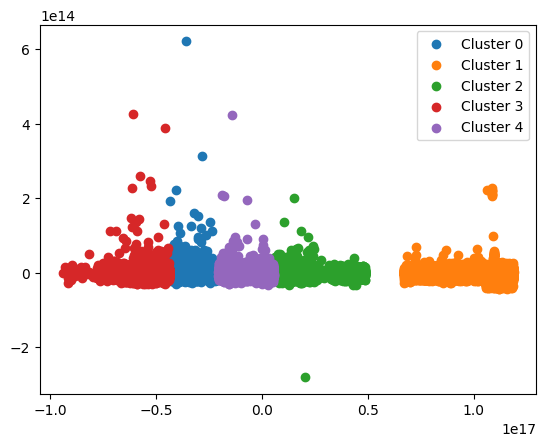

In [66]:
import numpy as np
import matplotlib.pyplot as plt
 
# Get unique labels
u_labels = np.unique(labels)
print(u_labels)

# Create scatter plot
for i in u_labels:
    plt.scatter(pca_result[labels == i , 0] , pca_result[labels == i , 1] , label= f'Cluster {i}')
plt.legend()
plt.show()